# Introducción: Práctica 1

**Alumno**: Iván Cañaveral Sánchez

En este notebook se afronta un problema de clasificación binaria de textos, apoyándonos principalmente en las librerías `sklearn`y `keras`.

El trabajo se estructura fundamentalmente en tres partes:
 - Una primera parte preparatoria (descarga de datos, importación de librerías, feature engineering y exploración de los datos).
 - Después se explora las distintas posibilidades que ofrecen técnicas de Machine Learning clásicas, y se intenta obtener un clasificador los mejores resultados posibles en base a las pruebas realizadas.
 - Se aplican técnicas de deep learning con el fin de dar pie a una introducción al tratamiento del lenguaje utilizando estas metodologías en los próximos temas.

 ⚠️ Esta práctica ha sido desarrollada y está pensada para ser revisada en un entorno de Google Colab.

# 1. Preparación

## Librerías y constantes

### Instalación

Instalamos deepchecks, una librería que utilizaremos más adelante para hacer algunas comprobaciones respecto a la distribución de los datos.

In [ ]:
!pip install -q deepchecks

     |████████████████████████████████| 3.6 MB 4.5 MB/s 
     |████████████████████████████████| 72 kB 582 kB/s 
     |████████████████████████████████| 11.2 MB 21.5 MB/s 
     |████████████████████████████████| 1.6 MB 48.9 MB/s 
     |████████████████████████████████| 965 kB 69.7 MB/s 


Nos aseguramos que la versión de `matplotlib` es la adecuada para maximizar la compatibilidad en los entornos de google colab.

In [ ]:
%%capture
!pip install matplotlib==3.1.3

### Importación

In [1]:
import os
import re
import json
import itertools
import numpy as np
import pandas as pd

In [2]:
from collections import Counter

In [3]:
from tqdm.notebook import tqdm_notebook

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(10,5)})

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve, ShuffleSplit, GridSearchCV, \
      cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
import nltk
from nltk.stem import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Descarga de datos

Para mejorar la usabilidad y reducir la complejidad de la obtención de los datos, hemos subido el dataset a un repositorio abierto de github, desde donde se pueden clonar sin problema.

En general no es una práctica recomendada mantener los datasets directamente en github (para ello existen aproximaciones más eficientes como DVC), pero dado el tamaño y la naturaleza del dataset, entendemos que no supone gran problema y facilita la ejecución del notebook. 

In [8]:
!git clone https://github.com/ivanCanaveral/msc-datasets/

Cloning into 'msc-datasets'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


## Carga de datos

Vamos a proceder a la carga de ambos datasets (train y test). Para hacer más sencillos algunos análisis, lo unificaremos en un único dataset, que dispondrá de la variable `partition: test|train` para poder filtrarlos fácilmente después.

In [9]:
raw_test_data = pd.read_csv('msc-datasets/movie-reviews/test_reviews.csv')
raw_train_data = pd.read_csv('msc-datasets/movie-reviews/train_reviews.csv')

In [10]:
raw_test_data['partition'] = 'test'
raw_train_data['partition'] = 'train'

In [11]:
dataset = pd.concat([raw_test_data, raw_train_data])
dataset.head()

,id,review,sentiment,partition
0,6666,Movies about dinosaurs can be entertaining. So...,negative,test
1,23267,If it's action and adventure you want in a mov...,positive,test
2,2897,Barbra Streisand is a tour de force in this Ho...,positive,test
3,23177,I borrowed this movie despite its extremely lo...,positive,test
4,14171,"""Baby Face"" is a precode melodrama starring a ...",positive,test


## Variables adicionales

En este apartado vamos a añadir algnas variables adicioinales sencillas que nos ayuden en la exploración y en la ejecución de los entrenamientos. Por ejemplo, añadiremos la longitud del texto, o una etiqueta numérica asociada a la variable `sentiment`.

Dado que se nos proporciona un `id` apra los textos, lo vamos a utilizar como índice del dataset.

In [12]:
dataset = dataset.set_index(dataset.id).drop(columns=["id"])

Vamos a añadir el número de palabras que tiene cada texto.

In [13]:
dataset["length"] = dataset.review.str.split().apply(len)
dataset.head()

,review,sentiment,partition,length
id,,,,
6666,Movies about dinosaurs can be entertaining. So...,negative,test,226
23267,If it's action and adventure you want in a mov...,positive,test,169
2897,Barbra Streisand is a tour de force in this Ho...,positive,test,188
23177,I borrowed this movie despite its extremely lo...,positive,test,487
14171,"""Baby Face"" is a precode melodrama starring a ...",positive,test,481


Y vamos a añadir una etiqueta numérica, que nos permitirá utilizarla directamente para entrenar los modelos.

Asignaremos el valor 1 a los textos marcados como `positive` y 0 a aquellos marcados como `negative`.

In [14]:
dataset['label'] = dataset.sentiment.apply(lambda x: 1 if x=='positive' else 0)
dataset['train_partition'] = dataset.partition == 'train'

Hemos añadido adicionalmente una variable booleana que nos indica si el texto pertenece a la partición de `train`, para agilizar filtrados.

En este momento el dataset tiene la siguiente estructura. El tratamiento que hemos realizado hasta el momento añade información redundante, pero no está orientado a la optimización de memoria, si no a facilitar la lectura y ejecución del notebook.

In [15]:
dataset.head(2)

,review,sentiment,partition,length,label,train_partition
id,,,,,,
6666,Movies about dinosaurs can be entertaining. So...,negative,test,226,0,False
23267,If it's action and adventure you want in a mov...,positive,test,169,1,False


## Exploración

En este apartado llevaremos a cabo una exploración analítica de los datos y su distribución. Fundamentalmente abordaremos los siguientes puntos:

* Exploración de etiquetas
* Exploración de texto
* Posibles desviaciones entre las particiones de test y train.

### Etiquetas

Exploramos las etiquetas de cada categoría. Es fundamental explorar cuántas hay, si existen inconsistencias entre ellas, y si disponemos de un dataset balanceado entre las distintas categorías.

In [16]:
dataset.groupby(by=["partition", "sentiment"]).count()

review  length  label  train_partition
partition sentiment                                        
test      negative     1025    1025   1025             1025
          positive      975     975    975              975
train     negative     3988    3988   3988             3988
          positive     4012    4012   4012             4012

No existen etiquetas que no sean "positive" o "negative", y disponemos de unos conjuntos de entrenamiento y de test equilibrados en cuanto a muestras de cada conjunto.

A priori disponemos de un dataset que tiene un nivel mínimo de preparación, y no nos hará (a priori) tener que aplicar técnicas para compensar un desbalanceo entre las distintas categorías.

### Textos

Vistas las etiquetas, vamos a hacer una revisión de la calidad y las cualidades de los textos.

#### Longitud

En primer lugar vamos a proceder a comprobar si existen textos vacíos. En un cálculo sencillo podemos obtener el porcentaje de textos nulos, o con menos de 5 palabras:

In [17]:
print('Porcentaje de textos nulos y con menos de 5 palabras: ', np.mean(dataset.review.isnull()), np.mean(dataset.length <= 5))

Porcentaje de textos nulos y con menos de 5 palabras:  0.0 0.0


Por suerte no diponemos de textos que podamos considerar "vacíos".

Profundicemos un poco más en las distribuciones de longitud. Para ello vamos a generar los histogramas de longitud. Adicionalmente añadimos la dimensión de la partición (test vs train), para comprobar que se distribuyen de manera similar.

[(0.0, 1100.0)]

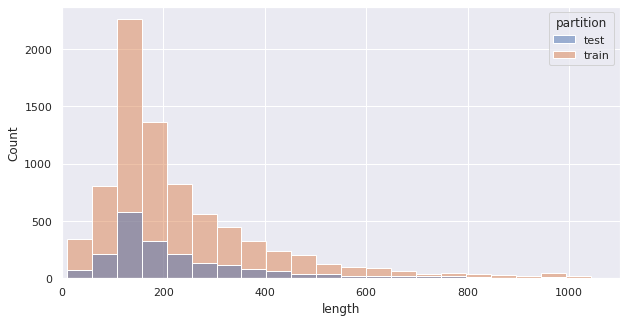

In [18]:
sns.histplot(data=dataset, x="length", hue="partition", bins=50).set(xlim=(0,1100))

En una primera exploración visual de los resultados, la distribución de los mismos no muestra anomalías, y ambas particiones se distribuyen de la misma manera.

Podríamos entrar en tests formales para comprobar que, efectivamente siguen la misma distribución, pero en este momento no parece que merezca la pena.

**Revisión de textos cortos y largos**

Vamos a revisar las etiquetas de los textos muy cortos y muy largos, para ver si podrían dar pié a potenciales sesgos.

Comencemos con los textos cortos:

In [19]:
dataset[dataset.length < 20]

,review,sentiment,partition,length,label,train_partition
id,,,,,,
12442,This movie is terrible but it has some good ef...,negative,test,10,0,False
3421,"A rating of ""1"" does not begin to express how ...",negative,train,18,0,True
1820,The characters are unlikeable and the script i...,negative,train,19,0,True
18006,Ming The Merciless does a little Bardwork and ...,negative,train,12,0,True


Los textos con menos de 20 palabras son todos negativos. Al explorar logintudes sensiblemente más largas hemos visto que comienzan a estar equilibradas ambas categorías, pero esto podría inferir un sesgo en algunos modelos.

Veamos qué ocurre con los más largos:

In [20]:
dataset[dataset.length > 1100]

,review,sentiment,partition,length,label,train_partition
id,,,,,,
2401,Titanic directed by James Cameron presents a f...,positive,test,1839,1,False
15445,I thought that ROTJ was clearly the best out o...,positive,train,1296,1,True
18182,The premise of this movie has been tickling my...,positive,train,1196,1,True
19063,Jim Carrey is back to much the same role that ...,positive,train,1277,1,True
18783,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive,train,2470,1,True


Vemos que los textos más largos son todos positivos. Cuando exploramos textos levemente más cortos encontramos también textos negativos.

Son pocos textos y no parece suponer un gran problema, pero habría que controlar los posibles sesgos debidos a longitud (que el modelo no aprenda que cualquier texto por debajo de 20 palabras es negativo, y por encima de 1100 es positivo, por ejemplo).

#### Limpieza de texto

En una exploración manual hemos visto que exiten fragmentos de html. De hecho, aproximadamente un 60% de los textos contienen el token `<br`, lo que nos indica que muchos textos podrían contener fragmentos de código html.

In [21]:
np.mean(dataset.review.str.contains('<br'))*100

58.84

Dado que exploraremos y trataremos los textos más adelante, esto debería quedar reflejado en la exploración, y lo trataremos en el preprocesado de los mismos.

**Preprocesado**

A continuación vamos a explorar el texto y vamos a intentar aplicar mejoras en la limpieza del mismo según vayamos analizando los resultados.

Para mejorar la lectura del código y el encapsulamiento del mismo, vamos a creamos una clase que hereda de las clases de estimadores de Sklearn. Adicionalmente, esto nos ayudará a hacer pruebas de manera sencilla con GridSearch.

⚠️ `WordNetLemmatizer()` no es un objeto serializable por `joblib` (una de las librerías que utiliza sklearn para paralelizar cálculos), por lo que ajustaremos la opción `njobs=1`, para evitar potenciales problemas.

Para, una vez más, aportar sencillez, vamos a establecer 3 tipos de preprocesado, que serán incrementales:

* `basic`: únicamente se hace una limpieza básica, pasando a minúsculas, filtrando caracteres indeseados y stopwords.
* `lemma`: sobre el tratamiento `basic` se aplica lemmatización.
+ `stem`: adicionalmente al lemmatizado, se aplica stemming.

In [28]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, level='basic'):
        assert level in ['basic', 'lemma', 'stem'], "Wrong level value"
        self.level = level
        self.apply_lemma = level != 'basic'
        self.apply_stem = level == 'stem'
    
    def clean_text(self, text):
        letters_only = re.sub("[^a-zA-Z]", " ", text)
        words = letters_only.lower().split()
        stops = set(stopwords.words("english") + ['br'])
        words = [w for w in words if not w in stops]
        return words

    def lemmatize_words(self, words):
        wordnet_lemmatizer = WordNetLemmatizer()
        lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in words]
        return lemmatized
    
    def stem_words(self, words):
        stemmer = PorterStemmer()
        stemmed = [stemmer.stem(word) for word in words]
        return stemmed

    def parse_text(self, text):
        words = self.clean_text(text)
        if self.apply_lemma:
            words = self.lemmatize_words(words)
        if self.apply_stem:
            words = self.stem_words(words)
        return " ".join(words)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.vectorize(self.parse_text)(X)

    def get_params(self, deep=True):
        return {
            "level": self.level
        }

Vamos a utilizar esta clase para preprocesar el texto y mejorar su calidad. Por sencillez, vamos a explorar la calidad de los textos a través de sus palabras más comunes.

#### Palabras más frecuentes

Vamos a utilizar el CountVectorizer de sklearn para contar las palabras más frecuentes. En su configuración vamos a incluir un filtrado que elimine las palabras que aparezcan en más de un 80% de los textos, lo que eliminará tokens extremadamente comunes y algunas stopwords altamente frecuentes (`in`, `for`, `a`, `the`, etc)

In [23]:
def get_word_counts(texts, vocab=None):
    counter = CountVectorizer(
        lowercase=True,
        max_df=0.80,
        min_df=0.001,
        vocabulary=vocab
    )
    word_counts = counter.fit_transform(texts)
    word_counts = {
        w:c for w,c in zip(
            counter.get_feature_names_out(), 
            word_counts.sum(axis=0).flatten().tolist()[0]
        )
    }
    return word_counts

Creamos también una función para generar un histograma de la frecuencia de palabras. Por defecto mostraremos las 20 más frecuentes, que nos dará una idea de los principales problemas del corpus.

In [24]:
def plot_word_count(word_count):
    print("Tamaño del vocabulario: ", len(word_counts.items()))
    pd.DataFrame.from_dict(
        word_counts,
        orient='index',
        columns=['count']
    ).sort_values(by='count', ascending=False).head(20).plot(kind='bar')

Tamaño del vocabulario:  10828


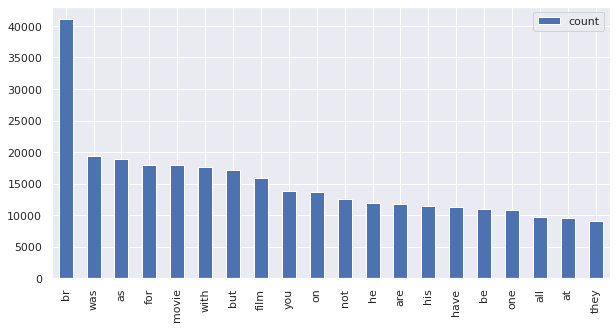

In [25]:
word_counts = get_word_counts(dataset.review)
plot_word_count(word_counts)

Vemos que aparece el token que ya habíamos anticipado (br), pero no parece haber una gran presencia de otros tags de html.

Vemos que existen numerosas stopwords, y distintas formas del mismo verbo. El tamaño del vocabulario supera las 10.000 palabras. Vamos a ver el impacto de aplicar un preprocesado básico.

In [29]:
basic_parser = TextPreprocessor(level='basic')

Tamaño del vocabulario:  10536


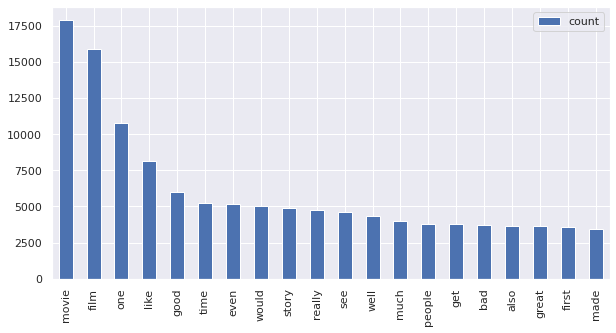

In [30]:
parsed_text = basic_parser.transform(dataset.review)
word_counts = get_word_counts(parsed_text)
plot_word_count(word_counts)

Las palabras más frecuentes tienen sentido, aunque se observa que necesitamos una normalización más avanzada del texto, y un proceso de lematización por ejemplo ayudaría a reducir la alta dimensionalidad (encontramos `characters` y `character` entre las palabras más utilizadas)

Aunque han desaparecido las stopwords, el impacto en la reducción del vocabulario sigue siendo pequeña (nos mantenemos por encima de las 10.000 palabras). 

Vamos a añadir el lemmatizado para eliminar el incremento de dimensionalidad debido a plurales y diferentes formas verbales.

In [31]:
lemma_parser = TextPreprocessor(level='lemma')

Tamaño del vocabulario:  9602


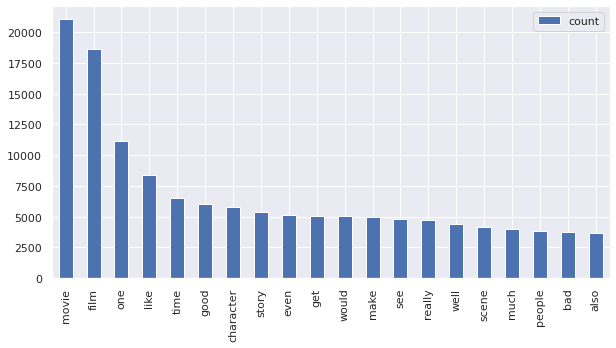

In [32]:
parsed_text = lemma_parser.transform(dataset.review)
word_counts = get_word_counts(parsed_text)
plot_word_count(word_counts)

Nos situamos finalmente por debajo de las 10.000 palabras, con una reducción de notable del vocabulario.

Viendo las palabras más frecuentes, existen dos potenciales problemas:
 * Palabras con la misma raiz pero diferentes formas. Veremos el impacto que tiene la eliminación de este fenomeno con la aplicación de `stemminig`.
 * Palabras muy frecuentes, pero con baja carga semántica (`get`, `much`, `also`, etc). Más adelante aplicaremos técnicas de pesado (tf-idf), para reducir él peso de estas y veremos su impacto.

 Pasemos a aplicar stemming y ver el resultado.

In [33]:
stem_parser = TextPreprocessor(level='stem')

Tamaño del vocabulario:  7865


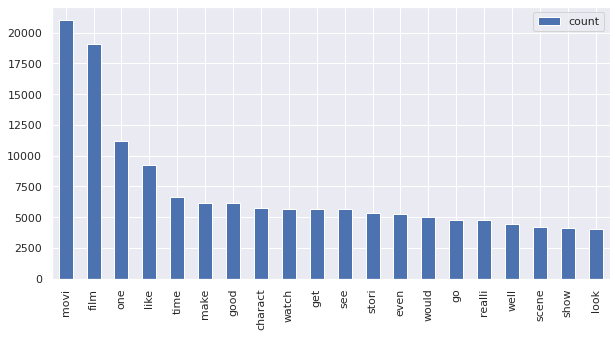

In [34]:
parsed_text = stem_parser.transform(dataset.review)
word_counts = get_word_counts(parsed_text)
plot_word_count(word_counts)

#### Correlaciones

Por último, antes de cerrar una primera exploración de los textos, vamos a hacer una vectorización preliminar y vamos a hacer un estudo global de las correlaciones, por si existiese alguna palabra con una correlación anormal con el output.

Esto es relativamente frecuente cuando se trabaja con textos procedentes de scraping web, donde en ocasiones se cuelan `tags` o cabeceras de secciones que aparecen en todos los artículos de una categoría y hacen que los modelos aprendan únicamente a clasificar en presencia de la misma.

Vamos a vectorizar los textos, y miraremos la correlación de todas las variables con la columna `label` del dataset.

In [35]:
counter = CountVectorizer(
    max_df=0.99,
    min_df=0.01,
    max_features=10_000
)

In [36]:
lemma_parser = TextPreprocessor(level='lemma')

In [38]:
counts = counter.fit_transform(lemma_parser.transform(dataset.review))
counts = pd.DataFrame(counts.toarray(), columns=counter.get_feature_names_out())
counts['label'] = dataset['label'].astype('int64').reset_index()['label']
counts['train_partition'] = dataset['train_partition'].astype('int64').reset_index()['train_partition']

In [39]:
%%time
correlation_matrix = counts.corr()

CPU times: user 1min 15s, sys: 194 ms, total: 1min 15s
Wall time: 1min 16s


Hemos calculado una matriz completa de correlaciones que podría utilizarse para otros análisis. En nuestro caso nos centraremos en las correlaciones con la variable `label`.

In [40]:
correlation_matrix['label'].sort_values(ascending=False)

label        1.000000
great        0.204702
excellent    0.163204
wonderful    0.153671
best         0.152663
               ...   
boring      -0.155334
awful       -0.180076
waste       -0.186959
worst       -0.228975
bad         -0.259968
Name: label, Length: 1650, dtype: float64

A parte de la correlación de la propia variable consigo misma, no se aprecian grandes correlaciones que no sean esperables. Como vemos, las palabras como "best" o "great", tienen correlaciones positibas, y "bad" o "worst" correlaciones negativas.

### Desviaciones train vs test

Para finalizar la exploración, deberíamos comprobar que las variables del dataset de entrenamiento y el de test siguen distribuciones similares. 

Dado que estamos usando vectorizaciones que generan una alta dimensionalidad, ejecutar tests estadísticos variable por variable suele ser poco práctico.

Una manera rápida de valorar esto es intentar entrenar un modelo que intente diferenciar entre el dataset de entrenamiento y el de test.

#### Modelo de detección de sesgos.

Aunque no es un método demasiado formal, entrenar un modelo que intente clasificar datos entre test y train es una manera efectiva de detectar grandes seesgos.

Para ello, vamos a generar un dataset, con una partición 80/20 y en cada una de ellas incluiremos datos del dataset original de train y de test. Utilizaremos el 80% del muestreo para entrenar y el 20% restante para validar el modelo resultante.

In [41]:
drift_detection_train, drift_detection_test = train_test_split(dataset, train_size=0.80)

Creamos un pipeline de clasificación sencillo, y lo entrenamos. Dado que las clases en este caso estarán claramente desbalanceadas, es importante especificar el parámetro `class_weight='balanced'` (comportamiento por defecto en la versión actual de sklearn).

In [42]:
drift_detection_model = Pipeline(
    steps=[
        ('text_preprocessor', TextPreprocessor(level='basic')),
        ('vectorizer', counter),
        ('classifier', SGDClassifier(loss='log', class_weight='balanced'))
    ]
)

In [43]:
%%time
drift_detection_model.fit(
    drift_detection_train.review, drift_detection_train.train_partition
)
outputs = drift_detection_model.predict(drift_detection_test.review)
print('% de acierto: ', np.mean(outputs == drift_detection_test.train_partition))

% de acierto:  0.553
CPU times: user 4.49 s, sys: 625 ms, total: 5.11 s
Wall time: 5.13 s


Vemos que la tasa de acierto del modelo es baja (en torno al 50%), lo cual no da pie a pensar que haya ningún problema grave.

De todas maneras, exploremos brevenente las etiquetas y los pesos del modelo, y vamos a utilizar una herramienta adicional para garantizar que no existen sesgos relevantes.

In [44]:
Counter(outputs)

Counter({False: 811, True: 1189})

In [45]:
drift_detection_test.groupby(by=['partition']).count()

,review,sentiment,length,label,train_partition
partition,,,,,
test,363,363,363,363,363
train,1637,1637,1637,1637,1637


In [46]:
weights = drift_detection_model.named_steps['classifier'].coef_[0]
words = drift_detection_model.named_steps['vectorizer'].get_feature_names_out()

In [50]:
model_weights = {wo:we for wo, we in zip(words, weights)}
model_weights = sorted(model_weights.items(), key=lambda item: item[1], reverse=True)

A continuación vemos las palabras con mayor y menor peso respectivamente dentro del modelo:

In [51]:
model_weights[:10]

[('thrown', 1.863124824213802),
 ('warning', 1.8568850924737281),
 ('unrealistic', 1.6617291988798675),
 ('product', 1.609375478674396),
 ('intelligent', 1.582672717289853),
 ('drive', 1.5231864900247851),
 ('brain', 1.422729458696743),
 ('opportunity', 1.3708429522433787),
 ('company', 1.337250747594477),
 ('answer', 1.2806605728499676)]

In [52]:
model_weights[-10:]

[('dr', -1.0411883896642637),
 ('latter', -1.0643058352836754),
 ('rarely', -1.1130813945858733),
 ('wooden', -1.1147173897568126),
 ('manage', -1.1608883434576212),
 ('floor', -1.1894096422057305),
 ('instance', -1.193568024377163),
 ('americans', -1.2063510419822892),
 ('anybody', -1.2348210827494253),
 ('commentary', -1.4733838215852975)]

No se observa nada llamativo más allá de las influencias marginales de unas u otras palabras debidas probablemente a un tamaño de dataset no muy grande. Debemos tener en cuenta que al tener por lo general más variables que téxtos, es frecuente observar estos comportamientos.

Esto es, puede que haya una palabra que aparezca una vez en el dataset, y el modelo se fije en ella para clasificarlo.

#### Medición de feature drift

Para finalizar, vamos a utilizar una librería que nos marcará las variables. Con deepchecks evaluaremos todas las variables y se comprobarán las potenciales desviaciones entre la partición de test y de train. 

Para que pueda evaluar los sesgos en todas las variables posibles, vamos a utilizar la matriz de conteos que se generó en el apartado anterior.

In [ ]:
from deepchecks.tabular.checks import TrainTestFeatureDrift

In [ ]:
counts[counts.train_partition==1].shape

In [ ]:
np.all(counts[counts.train_partition==0].columns == counts[counts.train_partition==1].columns)

In [ ]:
TrainTestFeatureDrift().run(
    counts[counts.train_partition==1].drop(columns=['train_partition']),
    counts[counts.train_partition==0].drop(columns=['train_partition'])
)

Vemos que la variable que mayor sesgo presenta es la propia varible 'partition'. Después de explorar el resto de variables con mayor sesgo, no se observa ninguna desviación importante en el dataset.

# Modelos Machine Learning

Vamos a explorar las capacidades que nos ofrecen los modelos clásicos de Machine Learning. En primer lugar, dados los propuestos en la práctica guiada, intentar explorar el impacto de los distintos parámetros relacionados con el tratamiento del texto y la vectorización.

A continuación, una vez entendido el impacto de los pasos previos, nos centraremos en evaluar distintos modelos y sus capacidades, intentando explorar sus distintas parametrizaciones.

## Tratamiento del texto y vectorización

Como avanzábamos, en esta sección vamos a hacer algunas pruebas con el fin de entender el impacto de los distintos parámetros de los que disponemos a la hora de tratar y vectorizar el texto.

### Tratamiento del texto

En el apartado anterior se lelvaron a cabo pruebas para evaluar el impacto en la calidad de los textos y la dimensionalidad.

Ahora vamos a ver cómo impacta en el entrenamiento los modelos.

Elegiremos tres modelos, que dejaremos fijos, y evaluaremos el impacto que el preprocesado tiene en la eficacia de los mismos. En concreto, evaluaremos el impacto de los tres niveles de tratamiento elegidos: `basic`, `lemma` y `stem`.

❗ Usaremos en este punto validación cruzada sobre todo el dataset (test+train) para agilizar el desarrollo.

Usaremos para estas pruebas:
* Regresión logística
* SVM
* Navie Bayes

In [ ]:
models = [
    ('log_reg', SGDClassifier(loss='log')),
    ('svm', SGDClassifier(loss='hinge')),
    ('naive_bayes', MultinomialNB())
]

In [ ]:
params = {
    'text_preprocessor__level': ['basic', 'lemma', 'stem'],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
}

Como anticipamos, vamos a medir el impacto del tratamiento del texto en el entrenamiento de los modelos. Evaluaremos los tres niveles definidos, para ver cómo afecta, sobretodo, la lematización y el stemming.

In [ ]:
results = []
for model_name, model in tqdm_notebook(models):
    pipe = Pipeline(
        memory='cache/vocab-size',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', CountVectorizer()),
            ('classifier', model)
        ]
    )
    grid_search = GridSearchCV(pipe, params, n_jobs=1)
    grid_search.fit(dataset.review, dataset.label)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['model'] = model_name
    results.append(cv_results)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
cv_results = pd.concat(results)
cv_results = cv_results.sort_values("model", ascending=False).reset_index()

model
log_reg        0.8288
naive_bayes    0.8412
svm            0.8291
Name: mean_test_score, dtype: float64

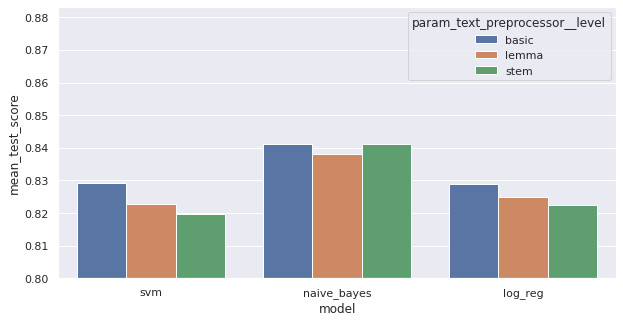

In [ ]:
chart = sns.barplot(data=cv_results, x='model', y='mean_test_score', hue='param_text_preprocessor__level')
chart.set(ylim=(0.80, None))
cv_results.groupby(by=['model']).max()['mean_test_score']

Curiosamente las técnicas de stemming y lematización muestran un descenso en la capacidad predictiva de los modelos.

Probablemente se deba a la reducción de dimensionalidad que provocan, dado que en este momento no se está acotando en número de variables.

Veamos un ejemplo donde se acota el número de variables. Utilizaremos el límite que asigna el CountVectorizer de sklearn, que elige las más frecuentes. Más adelante, utilizaremos técnicas de selección más complejas.

Fijamos un límite de 1.000 variables:

In [ ]:
params = {
    'text_preprocessor__level': ['basic', 'lemma', 'stem'],
    'vectorizer__max_features': [1_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
}

In [ ]:
results = []
for model_name, model in tqdm_notebook(models):
    pipe = Pipeline(
        memory='cache/vocab-size',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', CountVectorizer()),
            ('classifier', model)
        ]
    )
    grid_search = GridSearchCV(pipe, params, n_jobs=1)
    grid_search.fit(dataset.review, dataset.label)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['model'] = model_name
    results.append(cv_results)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
cv_results = pd.concat(results)
cv_results = cv_results.sort_values("model", ascending=False).reset_index()

model
log_reg        0.8334
naive_bayes    0.8318
svm            0.8309
Name: mean_test_score, dtype: float64

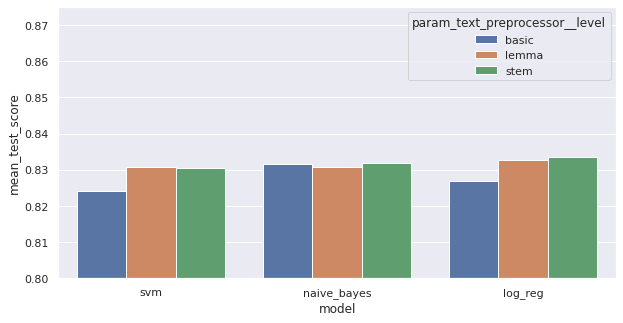

In [ ]:
chart = sns.barplot(data=cv_results, x='model', y='mean_test_score', hue='param_text_preprocessor__level')
chart.set(ylim=(0.80, None))
cv_results.groupby(by=['model']).max()['mean_test_score']

Vemos claramente que en presencia de una reducción de variables la lematización y el stemming tienen un efecto positivo en las capacidades del modelo.

De hecho, salvo en el caso de Naive Bayes que funciona mejor con mayor dimensionalidad, tanto SVM como la regresión logística aumentan su precisión.

### Vectorización

Veamos ahora cómo impactan los distintos cambios en la vectorización de los textos. Nos detendremos en 4 puntos:
* Acotar el número máximo de variables
* Inclusión de N-gramas
* Selección de variables
* Técnicas de pesado de variables.

#### Límite de variables

Vamos a variar de manera progresiva el límite de variables seleccionadas en la vectorización, y ver cómo impacta en la precisión de los modelos.

In [ ]:
params = {
    'text_preprocessor__level': ['stem'],
    'vectorizer__max_features': [10, 50, 100, 500, 1_000, 10_000, 50_000, 100_000],
}

In [ ]:
results = []
for model_name, model in tqdm_notebook(models):
    pipe = Pipeline(
        memory='cache/vocab-size',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', CountVectorizer()),
            ('classifier', model)
        ]
    )
    grid_search = GridSearchCV(pipe, params, n_jobs=1)
    grid_search.fit(dataset.review, dataset.label)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['model'] = model_name
    results.append(cv_results)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
cv_results = pd.concat(results).reset_index()

model
log_reg        0.8529
naive_bayes    0.8522
svm            0.8453
Name: mean_test_score, dtype: float64

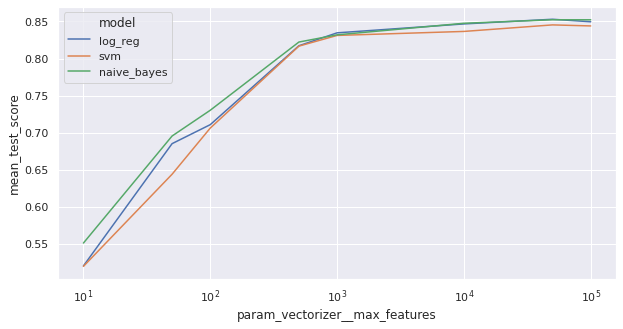

In [ ]:
chart = sns.lineplot(
    data=cv_results,
    x="param_vectorizer__max_features",
    y="mean_test_score",
    hue="model"
)
chart.set(xscale='log')
cv_results.groupby(by=['model']).max()['mean_test_score']

Vemos cómo en todos los modelos seleccionados, la precisión de los modelos crece proporcionalmente con el número de variables hasta llegar a las 1.000 variables. A partir de ese momento el efecto es mucho menos acusado. 

La precisión máxima ronda el 85%.

#### N-gramas

A continuación vamos a intentar ver cómo impacta la introducción de bigramas. Debemos tener en cuenta que esto generará un alto número de nuevas variables.

In [ ]:
params = {
    'text_preprocessor__level': ['stem'],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

In [ ]:
results = []
for model_name, model in tqdm_notebook(models):
    pipe = Pipeline(
        memory='cache/ngram-range',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', CountVectorizer()),
            ('classifier', model)
        ]
    )
    grid_search = GridSearchCV(pipe, params, n_jobs=1)
    grid_search.fit(dataset.review, dataset.label)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['model'] = model_name
    results.append(cv_results)

  0%|          | 0/3 [00:00<?, ?it/s]

model
log_reg        0.8232
naive_bayes    0.8416
svm            0.8207
Name: mean_test_score, dtype: float64

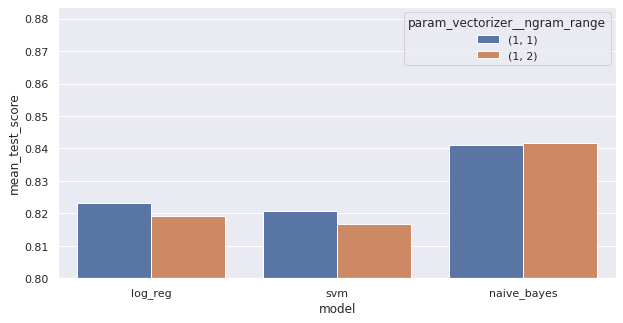

In [ ]:
cv_results = pd.concat(results)
chart = sns.barplot(
    data=cv_results,
    x='model',
    y='mean_test_score',
    hue='param_vectorizer__ngram_range')
chart.set(ylim=(0.80, None))
cv_results.groupby(by=['model']).max()['mean_test_score']

Curiosamente, la introducción de bigramas no mejora la precisión, salvo en el caso de Naive Bayes, aunque esta mejora es leve. Esto me hace sospechar que esta degradación de las métricas viene causada por el aumento brusco de la dimensionalidad. En este punto no estamos acotando la dimensionalidad.

Probaremos otro ejemplo acotando la dimensionalidad, sin embargo en este punto la sensación es que deberíamos utilizar una técnica de selección de variables más compleja, que simplemente elegir las más frecuentes, dado que los bigramas son menos frecuentes en general que los monogramas, y es probable perder bigramas que, aunque no muy frecuentes, tengan un impacto claro en la clasificación.

In [ ]:
params = {
    'text_preprocessor__level': ['stem'],
    'vectorizer__max_features': [10_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

In [ ]:
results = []
for model_name, model in tqdm_notebook(models):
    pipe = Pipeline(
        memory='cache/ngram-range',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', CountVectorizer()),
            ('classifier', model)
        ]
    )
    grid_search = GridSearchCV(pipe, params, n_jobs=1)
    grid_search.fit(dataset.review, dataset.label)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['model'] = model_name
    results.append(cv_results)

  0%|          | 0/3 [00:00<?, ?it/s]

model
log_reg        0.8239
naive_bayes    0.8416
svm            0.8232
Name: mean_test_score, dtype: float64

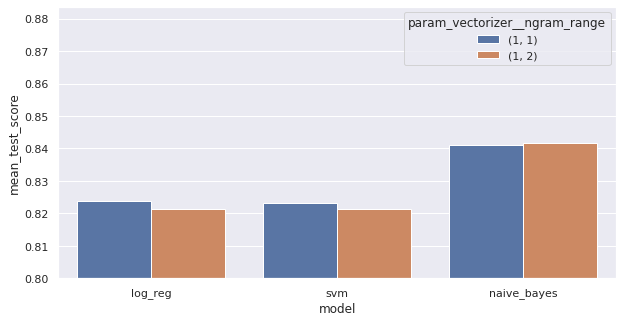

In [ ]:
cv_results = pd.concat(results)
chart = sns.barplot(
    data=cv_results,
    x='model',
    y='mean_test_score',
    hue='param_vectorizer__ngram_range')
chart.set(ylim=(0.80, None))
cv_results.groupby(by=['model']).max()['mean_test_score']

Al limitar el número de variables las diferencias se han reducido. Sin embargo, más adelante probaremos a combinarlo con otros sistemas de selección de variables, para evaluar mejor su impacto.

#### Selección de variables

A continuación vamos a estudiar el impacto de aplicar una selección de variables más sofisticada.

Utilizaremos dos métodos:
- Selección de variables eligiendo las n variables con más correlación con la variabel objetivo.
- Selección de variables aplicando regularización `l1` o `elasticnet` (combinación de normas)

##### Selección estadística

Utilizaremos un score basado en `chi2`, y elegiremos las `k` variables con una puntuación más alta.

In [ ]:
params = {
    'text_preprocessor__level': ['stem'],
    'vectorizer__max_features': [50_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'feature_selector__score_func': [chi2],
    'feature_selector__k': [10, 50, 100, 200, 500, 1_000, 2_000, 5_000]
}

In [ ]:
results = []
for model_name, model in tqdm_notebook(models):
    pipe = Pipeline(
        memory='cache/feature-selection',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', CountVectorizer()),
            ('feature_selector', SelectKBest()),
            ('classifier', model)
        ]
    )
    grid_search = GridSearchCV(pipe, params, n_jobs=1)
    grid_search.fit(dataset.review, dataset.label)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['model'] = model_name
    results.append(cv_results)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
cv_results = pd.concat(results).reset_index()

model
log_reg        0.8496
naive_bayes    0.8405
svm            0.8478
Name: mean_test_score, dtype: float64

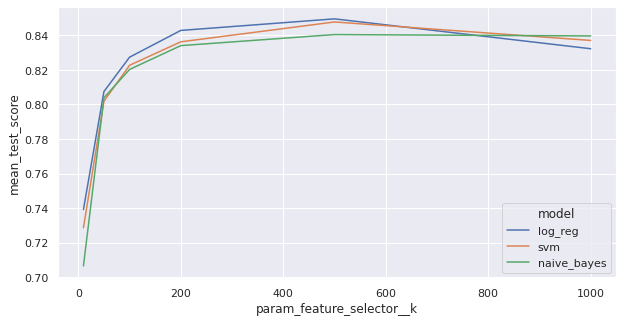

In [ ]:
chart = sns.lineplot(
    data=cv_results,
    x="param_feature_selector__k",
    y="mean_test_score",
    hue="model"
)
cv_results.groupby(by=['model']).max()['mean_test_score']

Vemos cómo se produce un pico de performance de los modelos, y llega un momento en el que añadir más variables no impacta en la precisión de los mismos. De hecho, para svm y regresión logística vemos como la precisión cae al aumentar las variables.

##### Selección por regularización

Vamos a comparar con algún método que lleva implícida la seección de variables, en lugar de aplicar un test estadístico. Al aplicar regularización, en función del coeficiente de penalización, muchas de ellas irán asociadas a un peso de cero.

De este modo, el criterio de selección no se basa en correlaciónn, si no que internamente el modelo lo descarta para ver si es relevante la información que aporta.

In [ ]:
pipe = Pipeline(
    memory='cache/feature-selection',
    steps=[
        ('text_preprocessor', TextPreprocessor()),
        ('vectorizer', CountVectorizer()),
        ('classifier', SGDClassifier())
    ]
)

El parámetro `alpha` modula la regularización, por tanto influyen directamente en la selección de variables. Vamos a variar progresivamente este valor y medir los resultados.

In [ ]:
params = {
    'text_preprocessor__level': ['stem'],
    'vectorizer__max_features': [50_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'classifier__loss' : ['log'],
    'classifier__penalty': ['l1', 'elasticnet'],
    'classifier__alpha': [
        1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 5*1e-05, 1e-01, 1.0
    ]
}

In [ ]:
%%time
grid_search = GridSearchCV(pipe, params, n_jobs=1)
grid_search.fit(dataset.review, dataset.label)
cv_results = pd.DataFrame(grid_search.cv_results_)

CPU times: user 14min 48s, sys: 15 s, total: 15min 3s
Wall time: 15min 20s


param_classifier__penalty
elasticnet    0.8535
l1            0.8285
Name: mean_test_score, dtype: float64

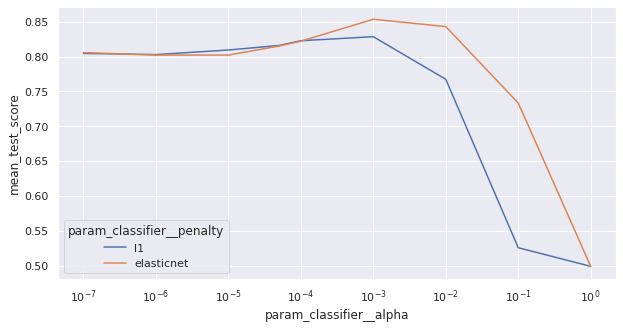

In [ ]:
chart = sns.lineplot(
    data=cv_results,
    x="param_classifier__alpha",
    y="mean_test_score",
    hue="param_classifier__penalty"
)
chart.set(xscale='log')
cv_results.groupby(by=['param_classifier__penalty']).max()['mean_test_score']

En ambos casos vemos como en valores cercanos a 10^(-3) se llega al pico de rendimiento, y después cae notablemente.

#### Pesado de variables

Finalmente vamos a evaluar cómo afecta la introducción de una técnica de pesado de variables como es TF-IDF. Hasta ahora hemos utilizado simplente los conteos de variables. 

In [ ]:
vectorizers = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_vectorizer', TfidfVectorizer())
]

In [ ]:
params = {
    'text_preprocessor__level': ['stem'],
    'vectorizer__max_features': [50_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'feature_selector__score_func': [chi2],
    'feature_selector__k': [10, 50, 100, 200, 500, 1_000, 2_000, 5_000]
}

In [ ]:
results = []
for model_name, model in tqdm_notebook(models):
    for vectorizer_name, vectorizer in tqdm_notebook(vectorizers):
      pipe = Pipeline(
          memory='cache/vectorizer',
          steps=[
              ('text_preprocessor', TextPreprocessor()),
              ('vectorizer', vectorizer),
              ('feature_selector', SelectKBest()),
              ('classifier', model)
          ]
      )
      grid_search = GridSearchCV(pipe, params, n_jobs=1)
      grid_search.fit(dataset.review, dataset.label)
      cv_results = pd.DataFrame(grid_search.cv_results_)
      cv_results['model'] = model_name
      cv_results['vectorizer'] = vectorizer_name
      results.append(cv_results)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

model        vectorizer      
log_reg      count_vectorizer    0.8475
             tfidf_vectorizer    0.8650
naive_bayes  count_vectorizer    0.8405
             tfidf_vectorizer    0.8450
svm          count_vectorizer    0.8419
             tfidf_vectorizer    0.8592
Name: mean_test_score, dtype: float64

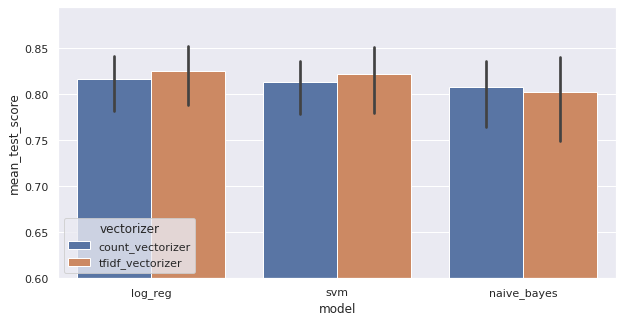

In [ ]:
cv_results = pd.concat(results).reset_index()
chart = sns.barplot(
    data=cv_results,
    x='model',
    y='mean_test_score',
    hue='vectorizer')
chart.set(ylim=(0.60, None))
cv_results.groupby(by=['model', 'vectorizer']).max()['mean_test_score']

En dos de los modelos el pesado de variables ha tenido un impacto positivo. En el caso de Naive Bayes, empeora levemente.

## Modelos



Después de explorar los distintos parámetros relativos al tratamiento y vectorización del texto, tenemos una idea clara de su impacto.

Vamos a explorar ahora los modelos en detalle.

In [53]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [54]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given
    labeled data using accuracy."""
    
    # Se realiza validación cruzada sobre el clasificador seleccionado
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
    classifier = GridSearchCV(
        estimator=estimator,
        cv=cv,
        param_grid=grid,
        error_score=0.0,
        n_jobs = 1,
        #verbose = 5
    )
    
    # Entrenamiento
    print("Training model")
    classifier.fit(X, yt)

    # Puntuación de la validación cruzada
    print("CV-scores for each grid configuration")
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    #for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
    #    print("Accuracy: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
    #print()
        
    # Curva de aprendizaje
    print("Learning curve for the best estimator")
    title = 'Learning Curves (' + str(estimator.__class__).replace("'>", "").split(".")[-1] + ' )'
    plot_learning_curve(classifier.best_estimator_, title, X, yt, cv=cv)
    plt.show()
    
    return classifier

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Para mejorar la legibilidad de las siguientes pruebas, vamos a separar los datasets de train y test en variables distintas.

In [56]:
train_dataset = dataset[dataset.partition=='train']
test_dataset = dataset[dataset.partition=='test']

### Naive Bayes

En nuestras pruebas este modelo respondía bien en entornos con un alto número de variables de inicio, aunque al aplicar una selección de las mismas, no mostraba mejoría a partir de unos pocos cientos de variables.

In [ ]:
nb_grid= {
    'text_preprocessor__level': ['lemma', 'stem'],
    'vectorizer__max_features': [100_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'feature_selector__score_func': [chi2],
    'feature_selector__k': [50, 100, 500, 1_000],
    'classifier__fit_prior': [True, False]
}

In [ ]:
nb_pipe = Pipeline(
        memory='cache/nb-pipe',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', TfidfVectorizer()),
            ('feature_selector', SelectKBest()),
            ('classifier', MultinomialNB())
        ]
    )

Training model
CV-scores for each grid configuration
Learning curve for the best estimator


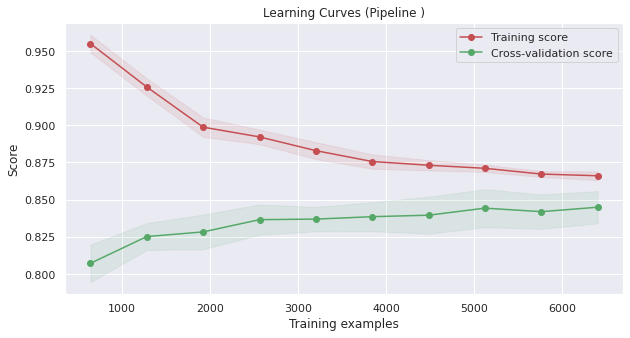

In [ ]:
nb_text_cls = train_and_evaluate_classifier(
    train_dataset.review, train_dataset.label, nb_pipe, nb_grid)

In [ ]:
print("Predicting on the test set")
y_pred = nb_text_cls.predict(test_dataset.review)

Predicting on the test set


Classification Report
              precision    recall  f1-score   support

    positive       0.86      0.81      0.83      1025
    negative       0.81      0.86      0.84       975

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Confusion matrix, without normalization


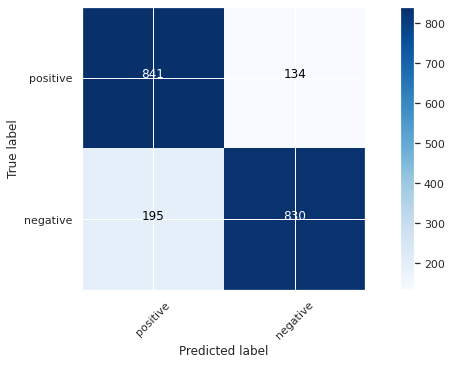

Final Accuracy
0.8355


In [ ]:
print("Classification Report")
print
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

En este caso hemos obtenido una Accuracy final de entorno al 83%.

### SVM

Vamos a evaluar ahora un SVM. Este método suele responder bien a problemas con alta dimensionalidad, y un número bajo de muestras, ya que intenta maximizar la distancia entre el hiperplano separador y las muestras más cercanas.

In [ ]:
svc_grid= {
    'text_preprocessor__level': ['lemma', 'stem'],
    'vectorizer__max_features': [100_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'feature_selector__score_func': [chi2],
    'feature_selector__k': [50, 100, 500],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': [0.0001]
}

In [ ]:
svc_pipe = Pipeline(
        memory='cache/svc-pipe',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', TfidfVectorizer()),
            ('feature_selector', SelectKBest()),
            ('classifier', SVC())
        ]
    )

Training model
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END classifier__C=1, classifier__gamma=0.0001, classifier__kernel=linear, feature_selector__k=50, feature_selector__score_func=<function chi2 at 0x7f5d206a9e60>, text_preprocessor__level=lemma, vectorizer__max_df=0.8, vectorizer__max_features=100000, vectorizer__min_df=0.01;, score=0.789 total time=  12.0s
[CV 2/5] END classifier__C=1, classifier__gamma=0.0001, classifier__kernel=linear, feature_selector__k=50, feature_selector__score_func=<function chi2 at 0x7f5d206a9e60>, text_preprocessor__level=lemma, vectorizer__max_df=0.8, vectorizer__max_features=100000, vectorizer__min_df=0.01;, score=0.793 total time=  12.4s
[CV 3/5] END classifier__C=1, classifier__gamma=0.0001, classifier__kernel=linear, feature_selector__k=50, feature_selector__score_func=<function chi2 at 0x7f5d206a9e60>, text_preprocessor__level=lemma, vectorizer__max_df=0.8, vectorizer__max_features=100000, vectorizer__min_df=0.01;, sco

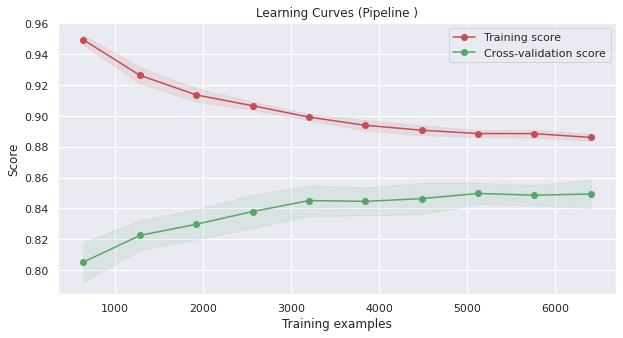

In [ ]:
svc_text_cls = train_and_evaluate_classifier(
    train_dataset.review, train_dataset.label, svc_pipe, svc_grid)

In [ ]:
print("Predicting on the test set")
y_pred = svc_text_cls.predict(test_dataset.review)

Predicting on the test set


Classification Report
              precision    recall  f1-score   support

    positive       0.87      0.83      0.85      1025
    negative       0.83      0.87      0.85       975

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Confusion matrix, without normalization


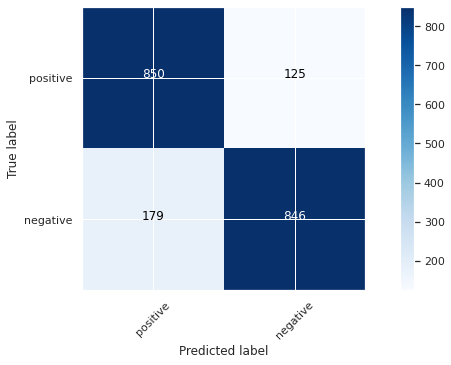

Final Accuracy
0.848


In [ ]:
print("Classification Report")
print
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

En este segundo modelo la accuracy ha quedado cerca del 85%.

### Log Reg

Probamos un clasificador de máxima entropía o regresión logística. Fijamos una selección de variables de entre 100 y 2000, a seleccionar entre un máximo de 100.000.

In [ ]:
log_grid= {
    'text_preprocessor__level': ['lemma', 'stem'],
    'vectorizer__max_features': [100_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'feature_selector__score_func': [chi2],
    'feature_selector__k': [100, 500, 1_000, 2_000],
    'classifier__loss' : ['log'],
    'classifier__penalty': ['l1', 'elasticnet'],
    'classifier__alpha': [
        1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 5*1e-05
    ]
}

In [ ]:
log_pipe = Pipeline(
        memory='cache/log-pipe',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', TfidfVectorizer()),
            ('feature_selector', SelectKBest()),
            ('classifier', SGDClassifier())
        ]
    )

Training model
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END classifier__alpha=1e-07, classifier__loss=log, classifier__penalty=l1, feature_selector__k=50, feature_selector__score_func=<function chi2 at 0x7f5d206a9e60>, text_preprocessor__level=lemma, vectorizer__max_df=0.8, vectorizer__max_features=100000, vectorizer__min_df=0.01;, score=0.782 total time=  10.9s
[CV 2/5] END classifier__alpha=1e-07, classifier__loss=log, classifier__penalty=l1, feature_selector__k=50, feature_selector__score_func=<function chi2 at 0x7f5d206a9e60>, text_preprocessor__level=lemma, vectorizer__max_df=0.8, vectorizer__max_features=100000, vectorizer__min_df=0.01;, score=0.791 total time=  10.9s
[CV 3/5] END classifier__alpha=1e-07, classifier__loss=log, classifier__penalty=l1, feature_selector__k=50, feature_selector__score_func=<function chi2 at 0x7f5d206a9e60>, text_preprocessor__level=lemma, vectorizer__max_df=0.8, vectorizer__max_features=100000, vectorizer__min_df=0.01;,

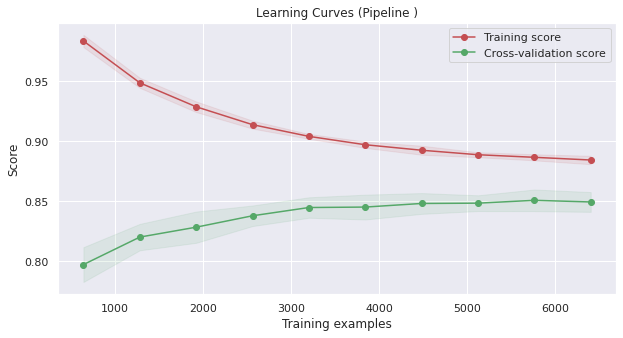

In [ ]:
log_text_cls = train_and_evaluate_classifier(
    train_dataset.review, train_dataset.label, log_pipe, log_grid)

In [ ]:
print("Predicting on the test set")
y_pred = log_text_cls.predict(test_dataset.review)

Predicting on the test set


Classification Report
              precision    recall  f1-score   support

    positive       0.88      0.83      0.85      1025
    negative       0.83      0.88      0.85       975

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Confusion matrix, without normalization


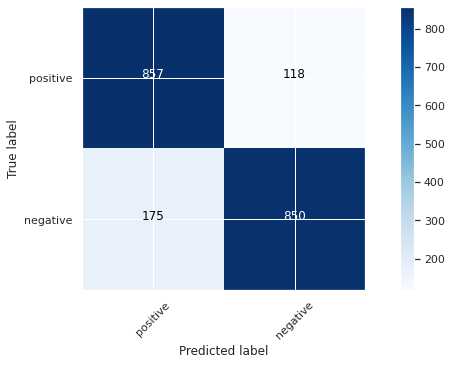

Final Accuracy
0.8535


In [ ]:
print("Classification Report")
print
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

En este caso el modelo obtiene una Accuracy superior al 85%, siendo el modelo con mayor precisión hasta el momento.

### DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree_grid= {
    'text_preprocessor__level': ['stem'],
    'vectorizer__max_features': [100_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'vectorizer__ngram_range': [(1, 2)],
    'feature_selector__score_func': [chi2],
    'feature_selector__k': [500, 1_000],
    'classifier__splitter' : ['best'],
    'classifier__max_depth': [None, 5, 10],
    'classifier__max_leaf_nodes': [None, 5, 10]
}

In [ ]:
tree_pipe = Pipeline(
        memory='cache/tree-pipe',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', TfidfVectorizer()),
            ('feature_selector', SelectKBest()),
            ('classifier', DecisionTreeClassifier())
        ]
    )

Training model
CV-scores for each grid configuration
Learning curve for the best estimator


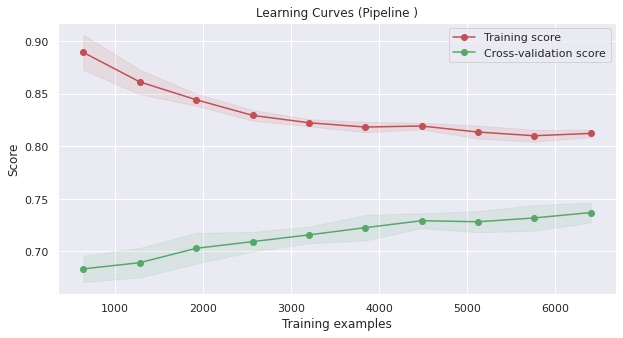

In [ ]:
tree_text_cls = train_and_evaluate_classifier(
    train_dataset.review, train_dataset.label, tree_pipe, tree_grid)

In [ ]:
print("Predicting on the test set")
y_pred = tree_text_cls.predict(test_dataset.review)

Classification Report
              precision    recall  f1-score   support

    positive       0.86      0.81      0.83      1025
    negative       0.81      0.86      0.84       975

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Confusion matrix, without normalization


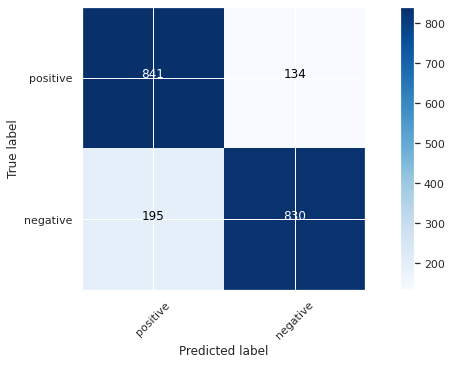

Final Accuracy
0.8355


In [ ]:
print("Classification Report")
print
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

### Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
gb_grid= {
    'text_preprocessor__level': ['stem'],
    'vectorizer__max_features': [50_000],
    'vectorizer__max_df': [0.8],
    'vectorizer__min_df': [0.01],
    'vectorizer__ngram_range': [(1, 2)],
    'feature_selector__score_func': [chi2],
    'feature_selector__k': [500, 1_000],
    'classifier__n_estimators' : [10, 50, 100],
    'classifier__max_depth': [None, 10],
    'classifier__max_leaf_nodes': [None, 10]
}

In [42]:
gb_pipe = Pipeline(
        memory='cache/gb-pipe',
        steps=[
            ('text_preprocessor', TextPreprocessor()),
            ('vectorizer', TfidfVectorizer()),
            ('feature_selector', SelectKBest()),
            ('classifier', GradientBoostingClassifier())
        ]
    )

Training model
CV-scores for each grid configuration
Learning curve for the best estimator


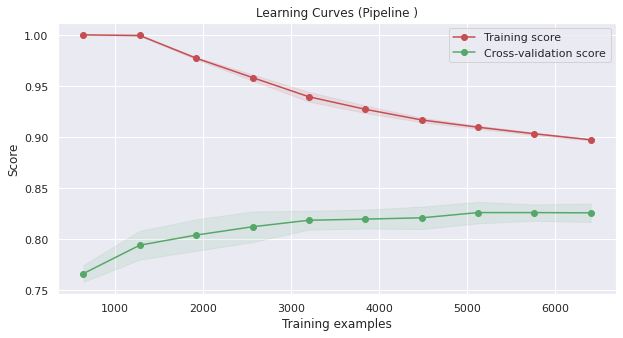

In [43]:
gb_text_cls = train_and_evaluate_classifier(
    train_dataset.review, train_dataset.label, gb_pipe, gb_grid)

In [47]:
y_pred = gb_text_cls.predict(test_dataset.review)

Classification Report

              precision    recall  f1-score   support

    positive       0.86      0.81      0.84      1025
    negative       0.81      0.86      0.84       975

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Confusion matrix, without normalization


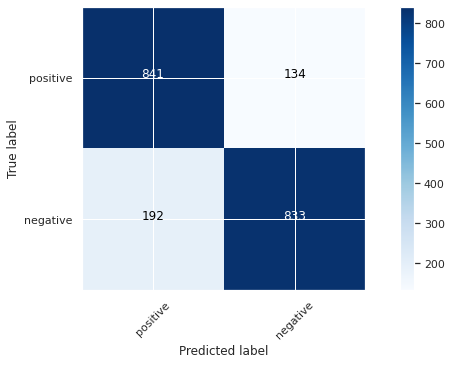

Final Accuracy
0.837


In [48]:
print("Classification Report")
print()
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

# Modelos Deep Learning

In [57]:
from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D
from keras import Sequential, Model, Input
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.initializers import Constant

In [58]:
# Con esta función podremos ver cómo evoluciona el entrenamiento y la validación de los modelos.

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Primer modelo.

Vamos a utilizar un preprocesado como los que hemos venido utilizando hasta el momento para los primeros modelos.

In [59]:
train_dataset = dataset[dataset.partition=='train']
test_dataset = dataset[dataset.partition=='test']

In [60]:
prep_pipeline = Pipeline(
    steps=[
        ('text_preprocessor', TextPreprocessor(level='stem')),
        ('vectorizer', TfidfVectorizer())
    ]
)

In [61]:
%%time
train_features = prep_pipeline.fit_transform(train_dataset.review)
test_features = prep_pipeline.transform(test_dataset.review)

CPU times: user 38.4 s, sys: 634 ms, total: 39 s
Wall time: 39.1 s


In [62]:
print("Dimensión del entrenamiento:", train_features.shape[1])

Dimensión del entrenamiento: 31106


Vamos a entrenar un modelo con más de 30.000 variables. En un modelo denso como el que vamos a utilizar en primera instancia esto hará que el número de parámetros de la primera capa sea relativamente alto.

Vamos a cambiar la codificación de las etiquetas para que respete el estilo "one-hot encoding" que espera keras.

In [63]:
y_train = to_categorical(train_dataset.label, num_classes=2)
y_test = to_categorical(test_dataset.label, num_classes=2)

Ahora generamos un modelo con la interfaz funcional, y lo compilamos.

In [64]:
model = Sequential()
model.add(Dense(128, input_dim=train_features.shape[1], activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3981696   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,990,082
Trainable params: 3,990,082
Non-trainable params: 0
_________________________________________________________________
None


Como anticipábamos, el número de parámetros de la primera capa es alto, llegando casi a los 4.000.000 de parámetros para ajustar. Es posible que el modelo sea sensible al overfitting, dado que nuestro dataset no es demasiado grande.

Llevemos a cabo el primer entrenamiento, con los parámetros siguientes parámetros:

In [65]:
#Número de épocas (iteraciones globales)
epochs = 40
#Dimensión de la capa de embeddings
emb_dim = 50
#Tamaño de batch (lote)
batch_size = 32
#Número de palabras tenidas en cuenta (reducción del vocabulario)
n_most_common_words = 50000
#Máxima longitud del documento
max_len = 512

Epoch 1/40
200/200 [==============================] - 5s 23ms/step - loss: 0.6933 - acc: 0.4920 - val_loss: 0.6932 - val_acc: 0.4831
Epoch 2/40
200/200 [==============================] - 5s 23ms/step - loss: 0.6932 - acc: 0.5023 - val_loss: 0.6933 - val_acc: 0.4831
Epoch 3/40
200/200 [==============================] - 5s 25ms/step - loss: 0.6932 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 0.4831
Epoch 4/40
200/200 [==============================] - 4s 22ms/step - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6929 - val_acc: 0.4894
Epoch 5/40
200/200 [==============================] - 5s 24ms/step - loss: 0.6922 - acc: 0.5706 - val_loss: 0.6910 - val_acc: 0.6500
Epoch 6/40
200/200 [==============================] - 4s 22ms/step - loss: 0.6824 - acc: 0.7552 - val_loss: 0.6670 - val_acc: 0.8438
Epoch 7/40
200/200 [==============================] - 4s 22ms/step - loss: 0.6168 - acc: 0.8864 - val_loss: 0.5774 - val_acc: 0.8512
Epoch 8/40
200/200 [==============================] - 6s 31ms/step - 

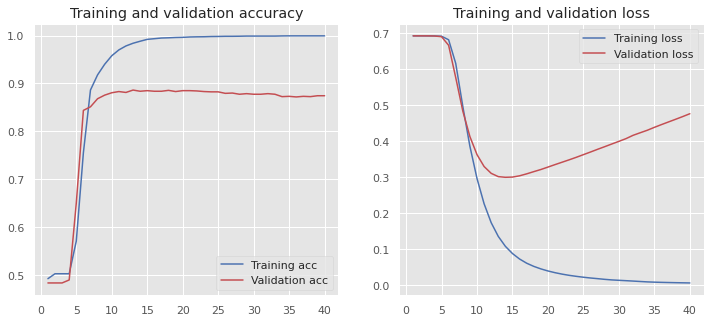

In [ ]:
history = model.fit(
    train_features.toarray().astype(float),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)
plot_history(history)

Vemso como el modelo tiende fuertemente al overfitting a partir de la epoch 15. La accuracy sobre la validación empieza a decrecer, y si atendemos a la función de pérdida, se sigue reduciendo en la partición de entrenamiento a costa de un incremento fuerte en la de validación.

Vamos a evaluar el rendimiento del modelo como lo hemos venido haciendo hasta ahora:

In [ ]:
print("Predicting on the test set")
y_pred = np.argmax(model.predict(test_features.toarray().astype(float)), axis=1)

Predicting on the test set
63/63 [==============================] - 1s 8ms/step


Classification Report

              precision    recall  f1-score   support

    positive       0.88      0.87      0.87      1025
    negative       0.87      0.87      0.87       975

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Confusion matrix, without normalization


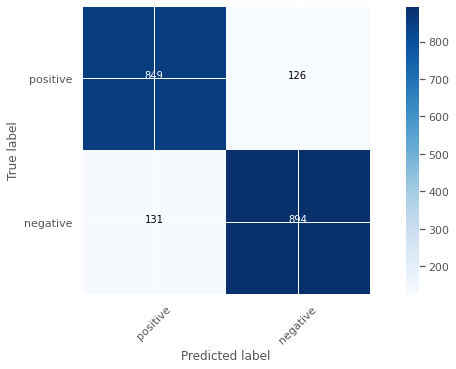

Final Accuracy
0.8715


In [ ]:
print("Classification Report")
print()
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

A pesar del problema mencionado, hemos obtenido un buen resultado. La accuracy está por encima del 87%, que es el mejor resultado obtenido hasta el momento.

## Segundo modelo. Reducción de overfitting.

Vamos a tomar algunas medidas para reducir el overfittnig. En primer lugar, vamos a utilizar un callbacl de Early Stopping.

In [67]:
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=7,
    min_delta=0.01
)

Generamos el modelo:


In [59]:
model = Sequential()
model.add(Dense(128, input_dim=train_features.shape[1], activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3981824   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,990,210
Trainable params: 3,990,210
Non-trainable params: 0
_________________________________________________________________
None


y volvemos a entrenar. Dado  que vamos a imprimir las curvas básicas de aprendizaje, reduciremos la cantidad de información que se muestra durante el entrenamiento (`verbose`: 0 = silent, 1 = progress bar, 2 = single line)

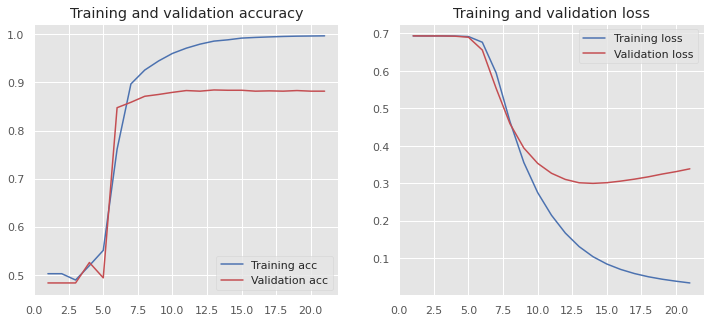

In [60]:
history = model.fit(
    train_features.toarray().astype(float),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping_cb],
    verbose=0
)
plot_history(history)

Predicting on the test set
63/63 [==============================] - 1s 11ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.89      0.87      0.88      1025
    negative       0.87      0.89      0.88       975

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

Confusion matrix, without normalization


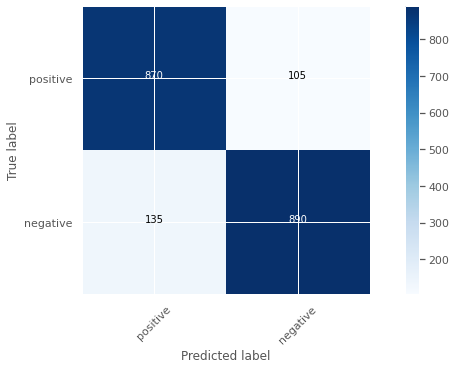

Final Accuracy
0.88


In [61]:
print("Predicting on the test set")
y_pred = np.argmax(model.predict(test_features.toarray().astype(float)), axis=1)

print("Classification Report")
print()
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

La accuracy llega al 88% con estos cambios.

#### Variación número de unidades en primera capa.

Vamos a ver cómo afecta el número de unidades en la primera capa:

In [31]:
results = []
for n in [1, 2, 4, 8, 16, 32, 64]:
    model = Sequential()
    model.add(Dense(n, input_dim=train_features.shape[1], activation='softmax'))
    model.add(Dense(min(32, n), activation='softmax'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    history = model.fit(
        train_features.toarray().astype(float),
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping_cb],
        verbose=0
    )

    y_pred = np.argmax(model.predict(test_features.toarray().astype(float)), axis=1)
    acc = accuracy_score(test_dataset.label, y_pred,)
    results.append({'n_units':n, 'acc': acc})

    print(f"Model accuracy with {n} units: {acc}")

63/63 [==============================] - 0s 3ms/step
Model accuracy with 1 units: 0.5125
63/63 [==============================] - 0s 6ms/step
Model accuracy with 2 units: 0.875
63/63 [==============================] - 0s 5ms/step
Model accuracy with 4 units: 0.877
63/63 [==============================] - 0s 4ms/step
Model accuracy with 8 units: 0.8795
63/63 [==============================] - 0s 5ms/step
Model accuracy with 16 units: 0.8785
63/63 [==============================] - 0s 6ms/step
Model accuracy with 32 units: 0.882
63/63 [==============================] - 1s 8ms/step
Model accuracy with 64 units: 0.8805


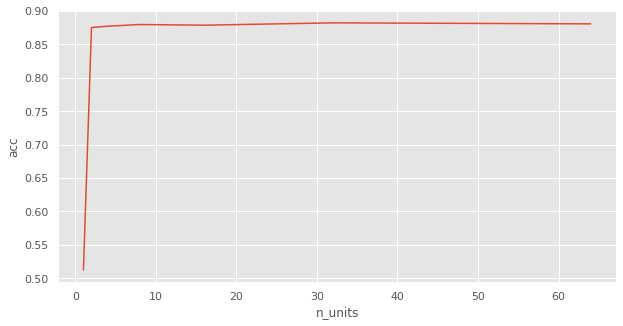

In [32]:
results = pd.DataFrame(results)
chart = sns.lineplot(
    data=results,
    x="n_units",
    y="acc"
)

A partir de dos unidades vemos como la precisión del modelo apenas varía. Añadir muchas unidades no está ayudando. Puede que esto venga provocado por la alta dimensionalidad del problema.

Si explorásemos los pesos, es probable que muchas de las unidades estén replicando los pesos de otras.

### Variación en la profundidad del modelo

Una vez medido el impacto del número de neuronas, veamos cómo influye la adicción de capas intermedias. En general, cuanto más profunda es una red, mayor capacidad de inferir patrones abstractos.

In [31]:
results = []
for n in range(5):
    model = Sequential()
    model.add(Dense(32, input_dim=train_features.shape[1], activation='softmax'))
    for _ in range(n):
      model.add(Dense(16, activation='softmax'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    history = model.fit(
        train_features.toarray().astype(float),
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping_cb],
        verbose=0
    )

    y_pred = np.argmax(model.predict(test_features.toarray().astype(float)), axis=1)
    acc = accuracy_score(test_dataset.label, y_pred,)
    results.append({'n_layers':n, 'acc': acc})

    print(f"Model accuracy with {n} hidden layers: {acc}")

63/63 [==============================] - 0s 6ms/step
Model accuracy with 0 hidden layers: 0.8785
63/63 [==============================] - 0s 5ms/step
Model accuracy with 1 hidden layers: 0.879
63/63 [==============================] - 0s 6ms/step
Model accuracy with 2 hidden layers: 0.877
63/63 [==============================] - 0s 5ms/step
Model accuracy with 3 hidden layers: 0.5125
63/63 [==============================] - 0s 5ms/step
Model accuracy with 4 hidden layers: 0.4875


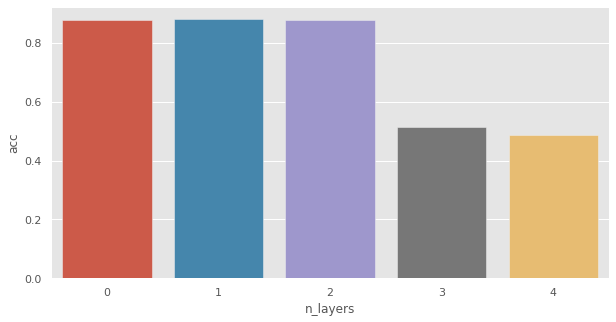

In [33]:
results = pd.DataFrame(results)
chart = sns.barplot(
    data=results,
    x="n_layers",
    y="acc"
)

Vemos que a partir de dos capas ocultas, la precisión empieza a caer. Dada la profundidad, y el "relativamente bajo" número de muestras, puede que el modelo esté sufriendo de algún problema de desvanecimiento de gradientes.

Vamos a ver qué ocurre si elevamos el número de epochs, para dar lugar a un entrenamiento más largo y ver si, sin necesidad de explorar los gradientes del modelo, hay algo indicativo de problemas con los gradientes.

In [72]:
model = Sequential()
model.add(Dense(32, input_dim=train_features.shape[1], activation='softmax'))
for _ in range(3):
    model.add(Dense(16, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

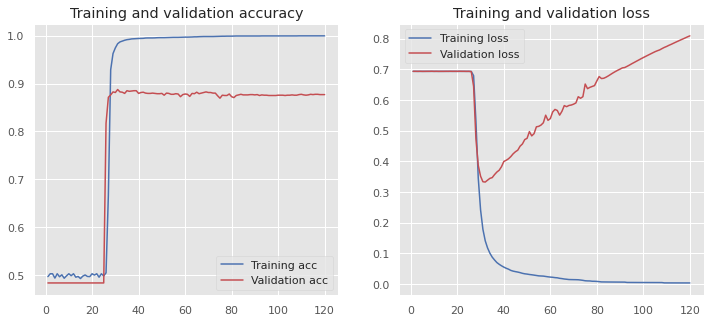

In [73]:
history = model.fit(
    train_features.toarray().astype(float),
    y_train,
    epochs=120,
    batch_size=batch_size,
    validation_split=0.2,
    #callbacks=[early_stopping_cb],
    verbose=0
)
plot_history(history)

Efectivamente, a parte de un pronunciado overfitting acusado a partir de la epoch 30, vemos algunos fenómenos indicadores de problemas con los gradientes. El más evidente de ellos es que durante las primeras 20 iteraciones el modelo es incapaz de aprender, lo que suele ocurrir en modelos profundos con problemas de desvanecimiento de gradientes.

### Dropout

Vamos a probar una de las técnicas más comunes para evitar el sobre ajuste de los modelos, el dropout. Con esta técnica, únicamente durante la fase de entrenamiento, se desactivarán algunas unidades, aplicando así un tipo de feature engineering interno.

In [74]:
from keras.layers import Dropout

In [76]:
model = Sequential()
model.add(Dense(128, input_dim=train_features.shape[1], activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               3981696   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 2)                 130       
                                                                 
Total params: 3,990,082
Trainable params: 3,990,082
Non-trainable params: 0
_________________________________________________________________
None


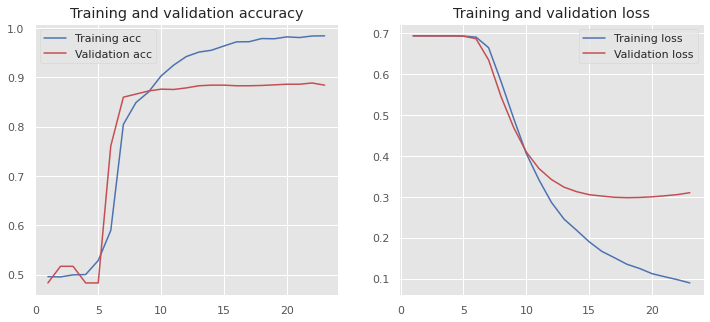

In [77]:
history = model.fit(
    train_features.toarray().astype(float),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping_cb],
    verbose=0
)
plot_history(history)

Predicting on the test set
63/63 [==============================] - 1s 14ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.88      0.88      0.88      1025
    negative       0.87      0.87      0.87       975

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

Confusion matrix, without normalization


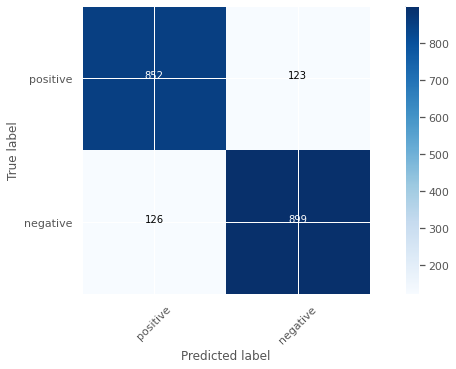

Final Accuracy
0.8755


In [78]:
print("Predicting on the test set")
y_pred = np.argmax(model.predict(test_features.toarray().astype(float)), axis=1)

print("Classification Report")
print()
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

El resultado es levemente mejor que el mejor que habíamos obtenido previamente.

### Reducción de parámetros

Vamos a entrenar un modelo con muchos menos parámetros, dado que hemos visto que un mayor número de unidades y capas no tenía tanto impacto, dado que modelos con alto número de parámetros fomentan el sobre ajuste.

In [79]:
model = Sequential()
model.add(Dense(4, input_dim=train_features.shape[1], activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 4)                 124428    
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_20 (Dense)            (None, 2)                 10        
                                                                 
Total params: 124,438
Trainable params: 124,438
Non-trainable params: 0
_________________________________________________________________
None


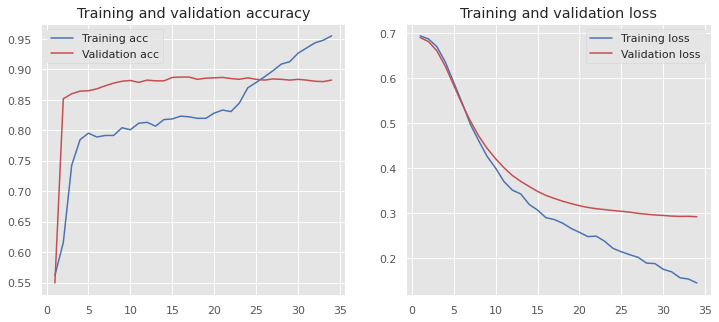

In [80]:
history = model.fit(
    train_features.toarray().astype(float),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping_cb],
    verbose=0
)
plot_history(history)

Predicting on the test set
63/63 [==============================] - 0s 4ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.89      0.87      0.88      1025
    negative       0.87      0.88      0.88       975

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

Confusion matrix, without normalization


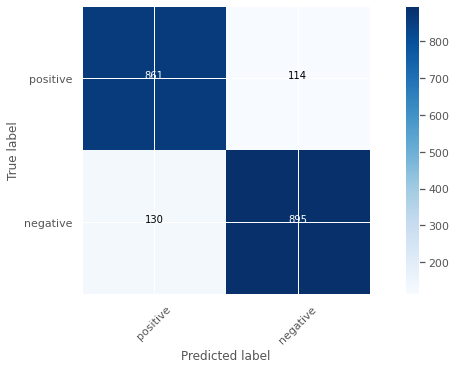

Final Accuracy
0.878


In [81]:
print("Predicting on the test set")
y_pred = np.argmax(model.predict(test_features.toarray().astype(float)), axis=1)

print("Classification Report")
print()
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

Aunque el incremento en precisión es leve, es el modelo más preciso que hemos obtenido hasta el momento.

## Tercer modelo. Custom Embeddings.

Vamos a entrenar un embedding custom incluído en el modelo para forzar una reducción de dimensionalidad.

Vamos a preprocesar los textos con nivel `lemma`, para que sean compatibles con embedding pre-entrenados en el siguiente apartado (no en este).

In [82]:
text_preprocessor = TextPreprocessor(level='lemma')

In [83]:
train_dataset = dataset[dataset['train_partition']]
test_dataset = dataset[~dataset['train_partition']]

In [84]:
train_texts = text_preprocessor.transform(train_dataset.review)
test_texts = text_preprocessor.transform(test_dataset.review)

Vamos a cambiar el sistema de vectorización. En este caso utilizaremos el Tokenizer de keras, que cambiará cada palabra por un índice, transformando cada texto en una secuencia de índices (uno por palabra en el texto). Se deberá fijar un tamaño exacto de texto (padding), para que las operaciones matriciales puedan llevarse a cabo (dado que cada texto tiene una longitud variable). En el tipo de vectorizaciones que hemos estado utilizando hasta ahora no era era necesario esto, proque todos los textos tenían la misma longitud tras la vectorización (una variable por palabra en el voacbulario).

In [85]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
sequences_train = tokenizer.texts_to_sequences(train_texts)
sequences_test = tokenizer.texts_to_sequences(test_texts)
vocab_size = len(tokenizer.word_index) + 1

In [86]:
print("Tamaño del vocabulario: ", vocab_size)

Tamaño del vocabulario:  41280


El vocabulario es algo mayor que utilizando la vectorización de sklearn.

Vamos a aplicar padding a los textos para que puedan ser compatibles con las operaciones matriciales.

In [87]:
train_text_nn = pad_sequences(sequences_train, maxlen=max_len)
test_text_nn = pad_sequences(sequences_test, maxlen=max_len)

In [88]:
y_train = to_categorical(train_dataset.label, num_classes=2)
y_test = to_categorical(test_dataset.label, num_classes=2)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=emb_dim, 
                           input_length=train_text_nn.shape[1]))
model.add(Flatten())
model.add(Dense(64, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 50)           2064050   
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dense_11 (Dense)            (None, 64)                1638464   
                                                                 
 dense_12 (Dense)            (None, 2)                 130       
                                                                 
Total params: 3,702,644
Trainable params: 3,702,644
Non-trainable params: 0
_________________________________________________________________
None


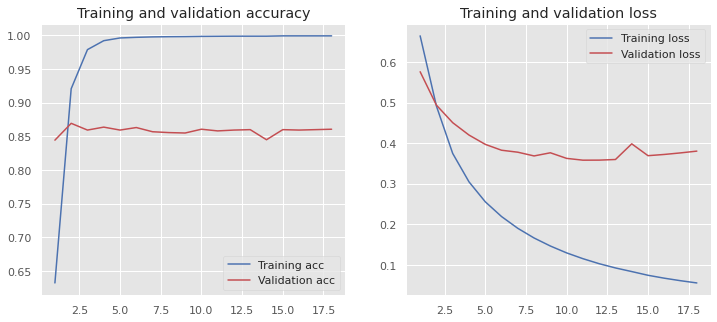

In [ ]:
history = model.fit(
    train_text_nn,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping_cb],
    verbose=0)
plot_history(history)

Predicting on the test set
63/63 [==============================] - 1s 8ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.88      0.86      0.87      1025
    negative       0.85      0.87      0.86       975

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Confusion matrix, without normalization


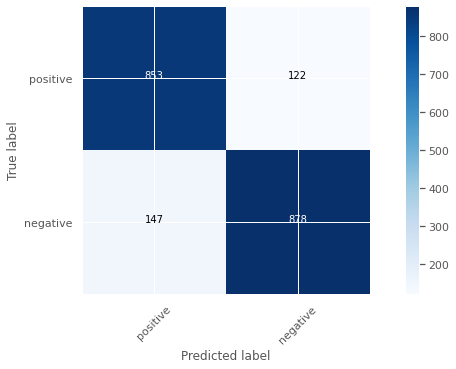

Final Accuracy
0.8655


In [ ]:
print("Predicting on the test set")
y_pred = np.argmax(model.predict(test_text_nn), axis=1)

print("Classification Report")
print()
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

El modelo muestra una precision algo inferior al experimento anterior, y la reducción del tamaño del modelo tampoco grande.

## Cuarto modelo. Embeddings pre-entrenados.

Vamos a comprobar el impacto que tendría un embedding pre entrenado. Para ello vamos a descargar los embeddings pre-entrenados de GloVe, que dispone de varias versiones de los mismos.

In [89]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-11-21 19:57:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-21 19:57:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-21 19:57:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Vamos a utilizar la versión de los embeddings pre-entrenados de 50 dimensiones.

In [90]:
EMB_SIZE = 50

In [91]:
embeddings_index = {}
f = open(f'glove.6B.{EMB_SIZE}d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Una vez cargados, veamos que cobertura de nuestro vocabulario ofrece el embedding pre-entrenado:

In [92]:
print('Found %s word vectors.' % len(embeddings_index))
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 400000 word vectors.
Found 41279 unique tokens.


In [93]:
n_missing = 0
num_words = min(n_most_common_words, len(word_index)) + 1

embedding_matrix = np.zeros((num_words, emb_dim))

for word, i in word_index.items():
    if i > n_most_common_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Si la palabra existe añadimos su vector a la matriz
        embedding_matrix[i] = embedding_vector
    else:
        # Si no existe, se le asigna un vector aleatorio
        embedding_matrix[i] = np.random.randn(emb_dim)
        n_missing += 1

In [94]:
print(len(word_index) - n_missing, 'tokens found.')

36381 tokens found.


In [95]:
print(n_missing, 'missing tokens.')

4898 missing tokens.


El embedding pre-entrenado no ha cubierto casi 5000 de las palabras de nuestro vocabulario. Para cada una de ellas se introducirá un vector aleatorio. Esto puede impactar en la calidad de los resultados.

Necesitamos modificar la capa de embeddings para incluir los embeddings Glove. Utilizando la matriz generada anteriormente, cargamos los valores de los embeddings pre-entrenados. Además, el parámetro "trainable" nos permite decidir si estos parámetros siguen siendo modificables (trainable = True) o lo mantenemos fijos durante todo el entrenamiento (trainable = False).

En este caso vamos a permitir que sufran cambios durante el entrenamiento.

In [ ]:
model = Sequential()
model.add(Embedding(num_words,
                    emb_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=train_text_nn.shape[1],
                    trainable=True))
model.add(Flatten())
model.add(Dense(64, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 50)           2064050   
                                                                 
 flatten_2 (Flatten)         (None, 25600)             0         
                                                                 
 dense_13 (Dense)            (None, 64)                1638464   
                                                                 
 dense_14 (Dense)            (None, 2)                 130       
                                                                 
Total params: 3,702,644
Trainable params: 3,702,644
Non-trainable params: 0
_________________________________________________________________
None


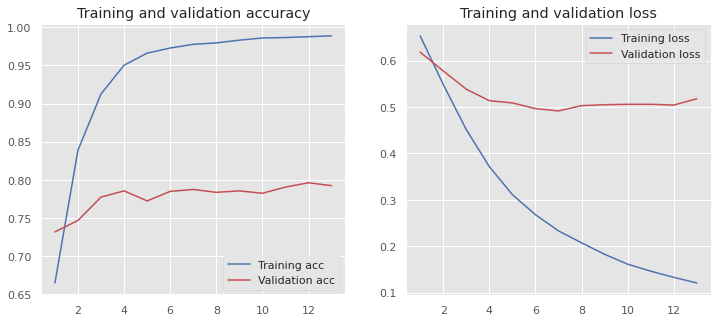

In [ ]:
history = model.fit(
    train_text_nn,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping_cb],
    verbose=0
    )
plot_history(history)

Predicting on the test set
63/63 [==============================] - 0s 6ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.78      0.78      0.78      1025
    negative       0.77      0.77      0.77       975

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000

Confusion matrix, without normalization


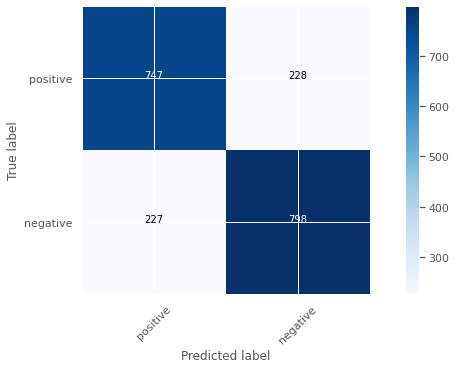

Final Accuracy
0.7725


In [ ]:
print("Predicting on the test set")
y_pred = np.argmax(model.predict(test_text_nn), axis=1)

print("Classification Report")
print()
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))

La precisión de este modelo es claramente inferior a los dos intentos anteriores. Esto probablemente se deba a dos factores principalmente:

- 5000 tokens sin vectorización, que pueden tener un impacto importante.
- Este embedding se ha entrenado de una manera generalista, sin estar especialmente adecuado al dominio de la tarea que estamos intentando resolver.

Una opción podría ser utilizar embeddings con mayor dimensionalidad, pero vamos por no perdernos en pruebas, vamos a tomar otro camino para finalizar la práctica.

### Cambios en los algoritmos de optimización y el learning rate

Al utilizar embeddings pre-entrenados estamos ante un caso particular de entrenamiento. Si bien cuando se entrena un modelo desde cero, el learning rate suele ser más agresivo, y cuando se reentrena o refina un modelo, el learning rate suele ser más reducido y el entrenamiento avanza más lentamente.

En este caso tenemos una parte preentrenada, pero otra que comienza de cero. Vamos a intentar aplicar otros optimizadores en combinación con un scheduler de learning rate. En concreo, utilizaremos uno que aplicará la reducción una vez que el aprendizaje comience a frenarse.

In [108]:
import math
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adam, Adagrad

In [128]:
learning_rate_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001)

In [132]:
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    min_delta=0.001
)

In [133]:
optimizers = [
    ('SGD', SGD()),
    ('RMSprop', RMSprop()),
    ('Adam', Adam()),
    ('Adagrad', Adagrad())
]

Optimizer:  SGD

Predicting on the test set
63/63 [==============================] - 1s 8ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.71      0.71      0.71      1025
    negative       0.70      0.69      0.69       975

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000

Confusion matrix, without normalization


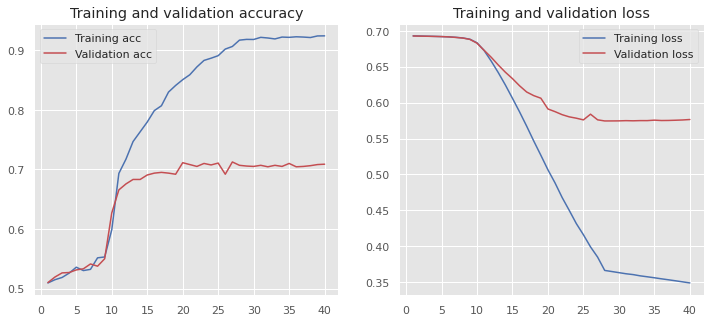

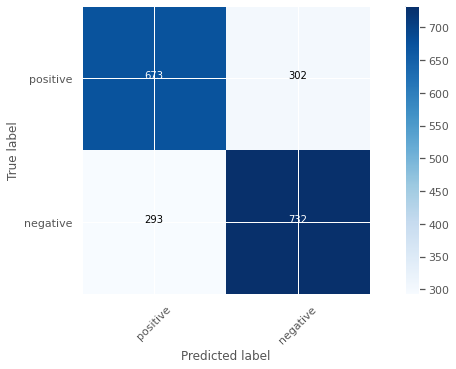

Final Accuracy
0.7025

Optimizer:  RMSprop

Predicting on the test set
63/63 [==============================] - 1s 7ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.79      0.81      0.80      1025
    negative       0.80      0.78      0.79       975

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000

Confusion matrix, without normalization


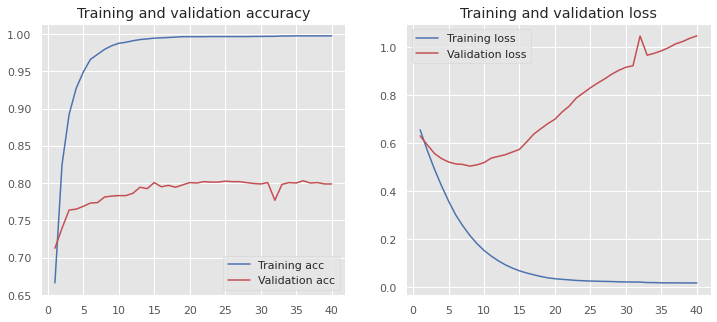

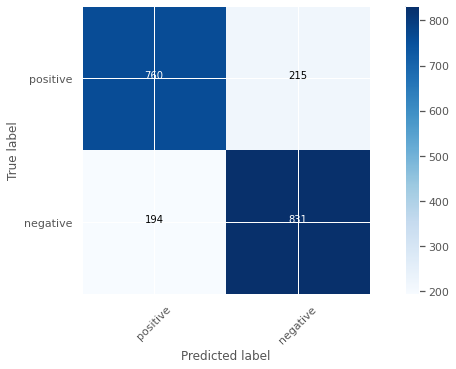

Final Accuracy
0.7955

Optimizer:  Adam

Predicting on the test set
63/63 [==============================] - 0s 6ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.78      0.80      0.79      1025
    negative       0.78      0.77      0.78       975

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000

Confusion matrix, without normalization


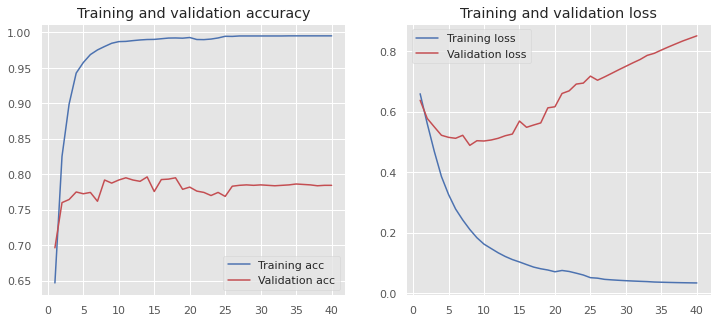

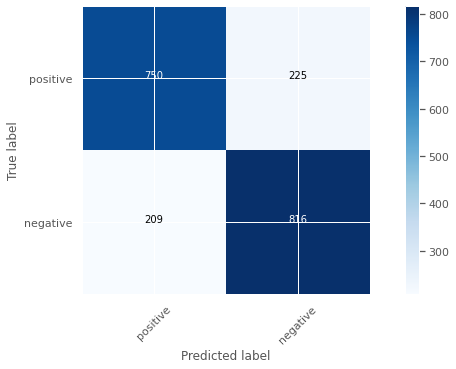

Final Accuracy
0.783

Optimizer:  Adagrad

Predicting on the test set
63/63 [==============================] - 1s 7ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.68      0.68      0.68      1025
    negative       0.66      0.67      0.67       975

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000

Confusion matrix, without normalization


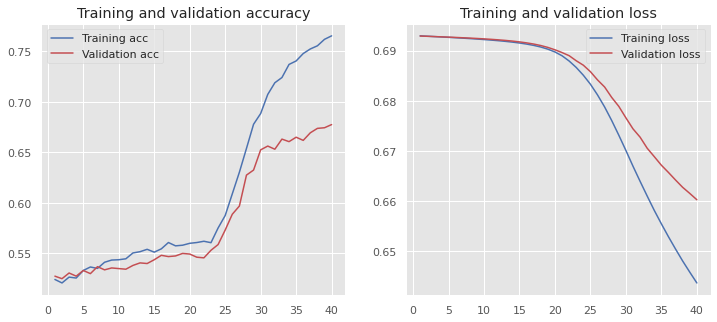

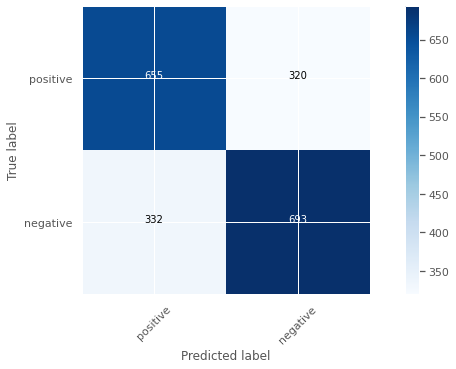

Final Accuracy
0.674



In [134]:
for opt_name, opt in optimizers:
    print('Optimizer: ', opt_name)

    # Arquitectura de modelo
    model = Sequential()
    model.add(Embedding(num_words,
                        emb_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=train_text_nn.shape[1],
                        trainable=True))
    model.add(Flatten())
    model.add(Dense(64, activation='softmax'))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['acc'],
    )

    # Entrenamiento
    history = model.fit(
        train_text_nn,
        y_train,
        epochs=40,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[learning_rate_cb],
        verbose=0,
        )
    plot_history(history)
    print()

    # Evaluación
    print("Predicting on the test set")
    y_pred = np.argmax(model.predict(test_text_nn), axis=1)

    print("Classification Report")
    print()
    print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
    cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])
    
    plot_confusion_matrix(cm, classes=["positive", "negative"])

    print("Final Accuracy")
    print(accuracy_score(test_dataset.label, y_pred,))
    print()

Vemos que se logran mejoras sobre lo obtenido previamente. Elegir el optimizador correcto y el ajuste del learning rate es en general un problema complejo, más si cabe en un problema en el que partimos de unos parámetros preentrenados como capa de entrada del modelo.

Vemos que en el último caso (Adagrad) no se produce tal mejora, pero las gráficas muestran que podría continuar mejorando, por lo que vamos a continuar con el entrenamiento algo más.


Predicting on the test set
63/63 [==============================] - 0s 6ms/step
Classification Report

              precision    recall  f1-score   support

    positive       0.72      0.72      0.72      1025
    negative       0.70      0.71      0.71       975

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000

Confusion matrix, without normalization


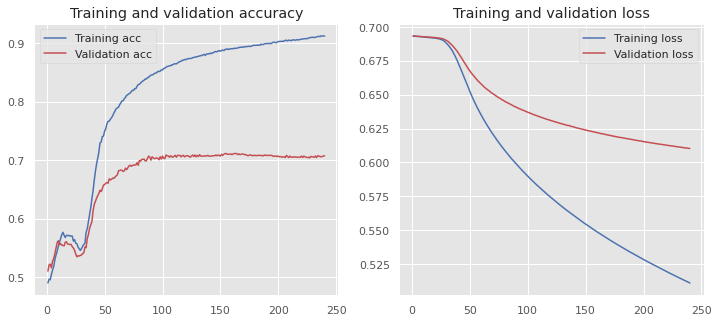

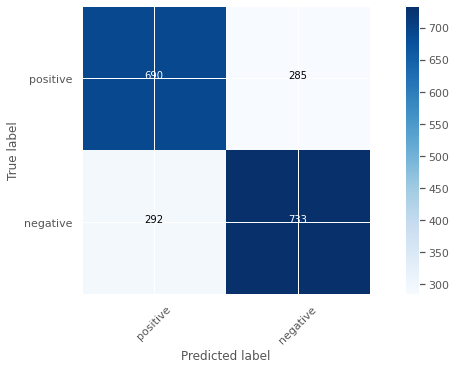

Final Accuracy
0.7115



In [136]:
model = Sequential()
model.add(Embedding(num_words,
                    emb_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=train_text_nn.shape[1],
                    trainable=True))
model.add(Flatten())
model.add(Dense(64, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.compile(
    optimizer=Adagrad(),
    loss='binary_crossentropy',
    metrics=['acc'],
)

# Entrenamiento
history = model.fit(
    train_text_nn,
    y_train,
    epochs=240,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[learning_rate_cb],
    verbose=0,
    )
plot_history(history)
print()

# Evaluación
print("Predicting on the test set")
y_pred = np.argmax(model.predict(test_text_nn), axis=1)

print("Classification Report")
print()
print(classification_report(test_dataset.label, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(test_dataset.label, y_pred, labels=[1, 0])

plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(test_dataset.label, y_pred,))
print()

El modelo ha continuado mejorando, aunque ha quedado por debajo de las puntuaciones alcanzadas con otros optimizadores.

# Conclusión

A lo largo de esta práctica hemos practicado, explorado y aprendido numerosos conceptos relacionados con la clasificación de textos. Queda claro que es un problema complejo, que involucra una gran complejidad computacional. En general se desprenden dos conclusiones:

* Un tratamiento tradicional puede obtener unos resultados relativamente buenos con aproximaciones sencillas.
* Técnicas más modernas, como las presentadas al final de la práctica requieren de un gran conocimiento teórico. Tienen un gran potencial, pueden llegar a superar ampliamente a los métodos tradicionales, pero requieren de un ajuste muy fino para que puedan llegar a explotar todas sus capacidades.